In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel"

# Matérn and Heat Kernels on the Stiefel manifold $\mathrm{V}(m, n)$

This notebook shows how define and evaluate kernels on the Stiefel manifold $\mathrm{V}(m, n)$ that consists of all orthonormal $m$-frames in $\mathbb{R}^n$, i.e. $m$-tupes of orthonormal vectors in $\mathbb{R}^n$.

Stiefel manifold is a homogeneous space space $\mathrm{V}(m, n) = \mathrm{SO}(n) / \mathrm{SO}(n-m)$ of the special orthogonal group $\mathrm{SO}(n)$. **Note**: mathematically, $\mathrm{V}(n, n) = \mathrm{SO}(n)$, the special orthogonal group, although our implementation requires $m < n$, and $\mathrm{V}(1, n) = \mathbb{S}_{n-1}$, the $n-1$-dimensional hypersphere.

We work with $\mathrm{V}(2, 5)$ here. There is no particular reason for this. Handling the Stiefel manifold $\mathrm{V}(m, n)$ for other $n \geq 2$ and $m < n$ is the same.


**Note:** the "points" in the the Stiefel manifold $\mathrm{V}(m, n)$ are represented by real matrices (`array`s of the suitable backend) of size $n \times m$, whose columns are orthonormal vectors.

We use the **numpy** backend here.

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualize Kernels](#Visualize-Kernels)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Comparing Kernels on $\mathrm{V}(1, n)$ to the Kernels on $\mathbb{S}_{n-1}$**](#Comparing-Kernels-on-$\mathrm{V}(1,-n)$-to-the-Kernels-on-$\mathbb{S}_{n-1}$)
- [**Citation**](#Citation)

## Basics

In [2]:
# add the parent directory to the path so that the library can be imported
import sys
sys.path.append("..")

In [10]:
# Import a backend, we use numpy in this example.
import numpy as np
#import torch

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
#import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Stiefel
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

### Defining a Space

First we create a GeometricKernels `space` that corresponds to the Stiefel manifold $\mathrm{V}(2, 5)$, a subset of the set of all $5 \times 2$ matrices $\mathbb{R}^{5 \times 2}$. Our implementation of `Stiefel` computes the basis functions (that are needed to compute all the kernels) approximately, using Monte Carlo integration. Because of this, you need to provide a source of randomness when constructing the space, i.e. the random generator of the suitable backend, via the `key` keyword argument.

**Note**: the aforementioned basis functions are *zonal spherical functions*, these are (sums of outer products of certain groups of Laplace-Beltrami eigenfunctions). Perhaps a close enough examination of "A theory of Stiefel harmonics" by S. S. Gelbart or similar literature could yield exact algorithms for computing them - an interesting problem for future research.

In [11]:
m, n = 2, 5

# key = torch.Generator()
# key.manual_seed(1234)
key = np.random.RandomState(1234)

key, stiefel = Stiefel(m=m, n=n, key=key)

### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `stiefel` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel.
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on compact manifold like (which $\mathrm{V}(m, n)$ are examples of) can be found on these documentation pages: [one](https://gpflow.github.io/GeometricKernels/theory/compact.html), [two](https://gpflow.github.io/GeometricKernels/theory/addition_theorem.html).

In [5]:
kernel = MaternGeometricKernel(stiefel)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [6]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [7]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

### Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points in $\mathrm{V}(2, 5)$.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [12]:
key, xs = stiefel.random(key, 10)

print(xs)

[[[-1.68504525e-01 -7.06026107e-01]
  [-3.44559305e-01  3.82891026e-01]
  [-7.14965754e-01  2.82130523e-01]
  [-1.78802389e-01  2.44485166e-01]
  [-5.56541811e-01 -4.64274671e-01]]

 [[ 1.44766060e-01  4.33768157e-01]
  [ 4.76064461e-01 -7.39636562e-01]
  [-7.21600150e-01 -1.65417307e-01]
  [ 3.16982053e-01  4.85213609e-01]
  [ 3.62244418e-01  4.45848561e-02]]

 [[ 5.55616377e-01 -3.52578323e-01]
  [-8.30863564e-03 -4.93089358e-01]
  [-6.64642273e-01 -5.99484224e-01]
  [-2.29826194e-01  4.73932665e-01]
  [-4.43454595e-01  2.20358584e-01]]

 [[-2.65366641e-02  4.74741540e-01]
  [ 8.32526574e-01  2.84360416e-02]
  [ 2.13244776e-02 -8.64126215e-01]
  [-5.23511589e-01  4.02248417e-02]
  [ 1.77978066e-01  1.59623644e-01]]

 [[ 2.65759578e-01  7.48397979e-01]
  [ 8.78333338e-01 -2.07538815e-01]
  [-1.01610144e-01 -4.66456000e-01]
  [ 2.07327168e-02  3.79658473e-01]
  [ 3.83598654e-01 -1.87366883e-01]]

 [[-6.09749906e-02  2.96035016e-03]
  [-1.92159119e-01 -6.61883174e-01]
  [-6.32788482e-01

Now we evaluate the two kernel matrices.

In [13]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

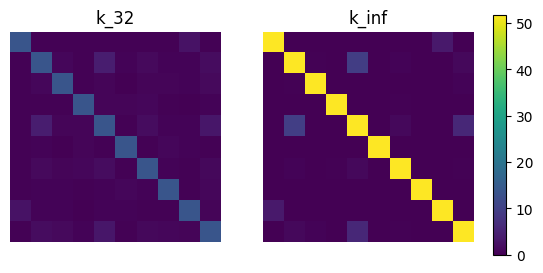

In [15]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualize Kernels

It is hard to visualize functions on $\mathrm{V}(m, n)$.
Functions are only easy to visualize on domains of dimension not higher than $2$.
However, we have $\dim \left(\mathrm{V}(m, n)\right) = n m - \frac{1}{2}m(m+1)$ which is greater than $2$ in all interesting cases.

In [SpecialOrthogonal.ipynb](./SpecialOrthogonal.ipynb), we visualize functions on the even more high-dimensional $\mathrm{SO}(n)$. To do this, we consider *random* embeddings $\mathbf{E}_{\mathbf{U}}: \mathbb{T} \hookrightarrow \mathrm{SO}(n)$ of the circle $\mathbb{T}$ into $\mathrm{SO}(n)$, visualizing $\tilde{f} \circ \mathbf{E}_{\mathbf{U}}: \mathbb{T} \to \mathbb{R}$ instead of the actual $\tilde{f}: \mathrm{SO}(n) \to \mathbb{R}$. Here, we use the canonical projection $\operatorname{P}: \mathrm{SO}(n) \to \mathrm{V}(m, n)$ to visualize $f \circ \operatorname{P} \circ \mathbf{E}_{\mathbf{U}}: \mathbb{T} \to \mathbb{R}$ instead of the actual $f: \mathrm{V}(m, n) \to \mathbb{R}$. The canonical projection $\operatorname{P}$ is something as simple as the operation of extracting the first $m$ columns of an $n \times n$ matrix.

To sum up, we will plot the functions $k_{\nu, \kappa}(\operatorname{P} \mathbf{I}, \operatorname{P} \mathbf{E}_{\mathbf{U}}(\alpha))$ where
- $\mathbf{I}$ is the $n \times n$ identity matrix,
- $\alpha \in \mathbb{T}$ and thus can be represented as an angle in $[0, 2 \pi)$,
- $\operatorname{P}$ is the canonical projection of $\mathrm{SO}(n)$ onto $\mathrm{V}(m, n)$, as explained above,
- $\mathbf{E}_{\mathbf{U}}(\alpha)$ is the random embedding of $\mathbb{T}$ into $\mathrm{SO}(n)$ defined in [SpecialOrthogonal.ipynb](./SpecialOrthogonal.ipynb).

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points1` or $x \in $ `other_points2`.
The `base_point` is simply $\operatorname{P} \mathbf{I}$.
The `other_points1` and `other_points2` are defined by the `_NUM_ANGLES` uniform discretization of the unit circle, but with different $\mathbf{U}$, i.e. corresponding to different random embeddings of $\mathbb{T}$ into $\mathrm{SO}(n)$.

We define `base_point`, `other_points`, and `other_points2` in the next cell.

In [16]:
# define discretization
_NUM_ANGLES = 128

key, U = stiefel.G.random(key, 2)  # stiefel.G returns an object representing SO(n)
U1 = U[0, :]
U2 = U[1, :]

# generate a grid on [0, 2 \pi)
angles = np.linspace(0, 2*np.pi, num=_NUM_ANGLES)
embedding = np.broadcast_to(np.eye(n), (_NUM_ANGLES, n, n)).copy()
embedding[:, 0, 0] = np.cos(angles)
embedding[:, 0, 1] = -np.sin(angles)
embedding[:, 1, 0] = np.sin(angles)
embedding[:, 1, 1] = np.cos(angles)

base_point = stiefel.project_to_manifold(embedding[[0], :, :])

def conj_batch(U, emb):
    """ Compute U^T * emb[i, :] * U for all i.
    :param U:   [n, n] array
    :param emb: [N, n, n] array
    
    :return:    [N, n, n] array
    """
    return np.tensordot(np.tensordot(emb, U, axes=([2], [0])),
                        U.T, axes=([1], [1])
                       )

other_points1 = stiefel.project_to_manifold(conj_batch(U1, embedding))
other_points2 = stiefel.project_to_manifold(conj_batch(U2, embedding))

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points1` and $x \in $ `other_points2`, for $\nu$ either $3/2$ or $\infty$.

In [17]:
kernel_vals_32_1  = kernel.K(params_32,  base_point, other_points1)
kernel_vals_32_2  = kernel.K(params_32,  base_point, other_points2)
kernel_vals_inf_1 = kernel.K(params_inf, base_point, other_points1)
kernel_vals_inf_2 = kernel.K(params_inf, base_point, other_points2)

Finally, we are ready to plot the results.

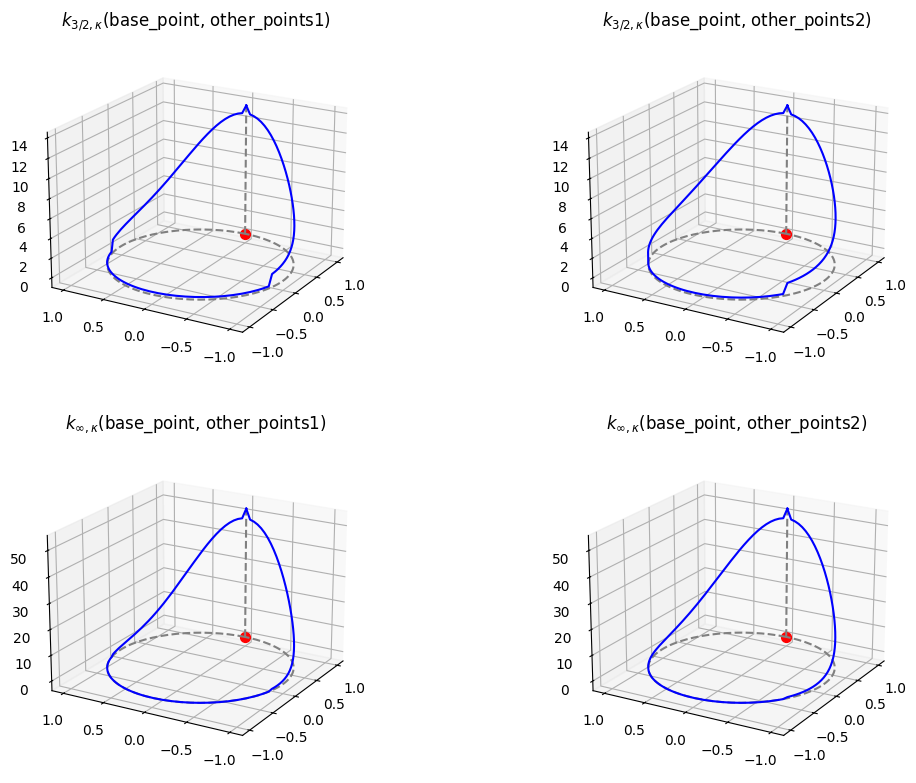

In [18]:
x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

# Red ball position
red_ball_position = (x_circle[0], y_circle[0], z_circle[0])


def plot_kernel(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Draw the red ball
    ax.scatter(*red_ball_position, color="r", s=50)
    # Draw the vertical dashed line
    ax.plot([1, 1], [0, 0], np.linspace(0, values[0, 0], 2), linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values[0, :], color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_kernel(ax1, kernel_vals_32_1,  r'$k_{3/2, \kappa}($base_point, other_points1$)$')
plot_kernel(ax2, kernel_vals_32_2,  r'$k_{3/2, \kappa}($base_point, other_points2$)$')
plot_kernel(ax3, kernel_vals_inf_1, r'$k_{\infty, \kappa}($base_point, other_points1$)$')
plot_kernel(ax4, kernel_vals_inf_2, r'$k_{\infty, \kappa}($base_point, other_points2$)$')


# Display the plot
plt.show()

## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the sphere, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [19]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the (hyper)sphere, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `Stiefel` space, the first element is `key` since the feature map is *random*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [20]:
# xs are random points from above
key, embedding = feature_map(xs, params_32, key=key)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

MemoryError: Unable to allocate 55.9 GiB for an array with shape (300000000, 25) and data type float64

**Unfortunately:** $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$ does not hold, which is either caused by a bug or by the insufficiency of the default approximation order in this case. **TODO:** investigate this.

### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.
Since we are going to compute each of the two samples at two different sets of inputs, `other_points1` and `other_points2`, we make sure the randomness if fixed by using the `make_deterministic` function.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
**However**, in our specific case, this keyword argument is not needed as it is automatically supplied by the `make_deterministic` wrapper.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [15]:
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

sample_paths = make_deterministic(sampler(feature_map, s=2), key)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.13170482  2.01510106]
 [-0.51298715  0.68596572]
 [ 0.1935511   1.44418376]
 [-0.45585541 -0.56276565]
 [-1.06861039  0.76202012]
 [ 0.55645202 -0.1353456 ]
 [ 1.01395638  0.58231461]
 [ 1.67218586 -0.49687743]
 [-0.75457651 -0.47982306]
 [ 0.77365106  0.92118493]]


#### Visualizing Samples
Here we visualize samples as functions on the sphere.

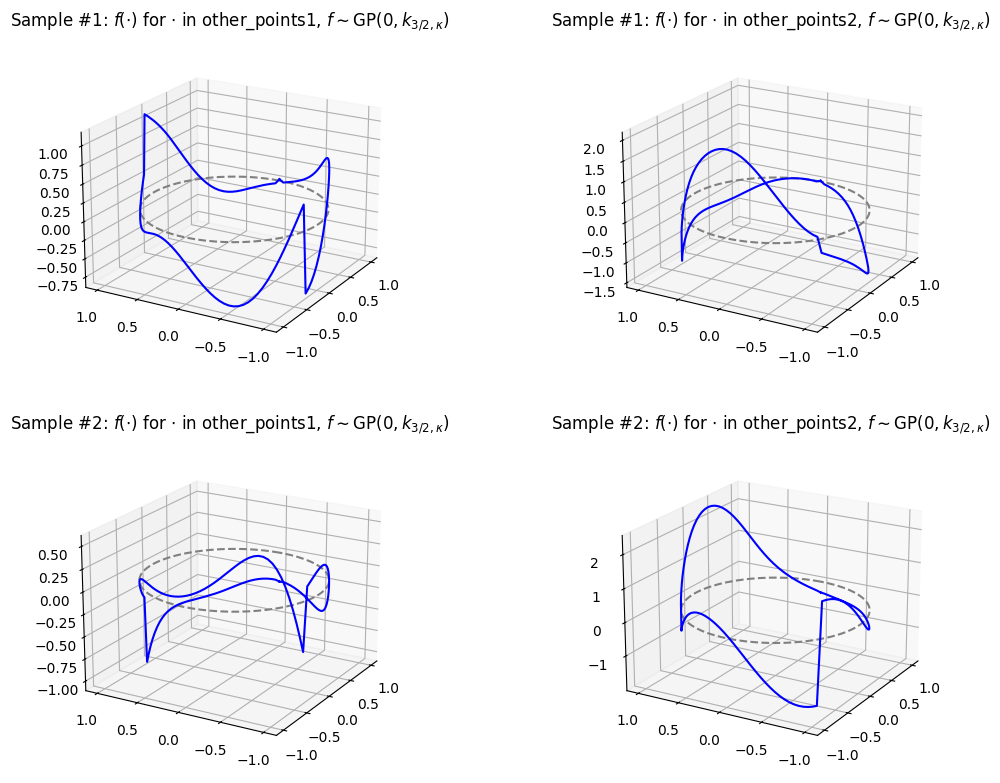

In [16]:
key, samples_other_points1 = sample_paths(other_points1, params_32)
key, samples_other_points2 = sample_paths(other_points2, params_32)

sample1_other_points1 = samples_other_points1[:, 0]
sample2_other_points1 = samples_other_points1[:, 1]
sample1_other_points2 = samples_other_points2[:, 0]
sample2_other_points2 = samples_other_points2[:, 1]

x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

def plot_sample(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values, color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_sample(ax1, samples_other_points1[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax2, samples_other_points2[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax3, samples_other_points1[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax4, samples_other_points2[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Display the plot
plt.show()

## Comparing Kernels on $\mathrm{V}(1, n)$ to the Kernels on $\mathbb{S}_{n-1}$

Here we show that—up to approximation error—the kernels on $\mathrm{V}(1, n)$ coincide with the kernels on $\mathbb{S}_{n-1}$, as they are supposed to since $\mathrm{V}(1, n) = \mathbb{S}_{n-1}$.

In [17]:
from geometric_kernels.spaces import Hypersphere

n = 5

key = np.random.RandomState(1234)

key, stiefel_1n = Stiefel(m=1, n=n, key=key)
hypershpere = Hypersphere(n-1)

kernel_stiefel_1n = MaternGeometricKernel(stiefel_1n)
kernel_hypershpere = MaternGeometricKernel(hypershpere, num=8)

params_32  = {"lengthscale": np.array([0.125]), "nu": np.array([3/2])}
params_inf = {"lengthscale": np.array([0.125]), "nu": np.array([np.inf])}

In [18]:
key = np.random.RandomState(1234)

key, xs_hypersphere = hypershpere.random(key, 10)
xs_stiefel = xs_hypersphere[..., np.newaxis]

**Note:** the elements of `hypershpere` and the elements of `stiefel_1n` have different shapes: the former are $n$-dim vectors while the latter are $n \times 1$-dim matrices.

In [19]:
kernel_stiefel_1n_mat_32   = kernel_stiefel_1n.K(params_32,  xs_stiefel, xs_stiefel)
kernel_stiefel_1n_mat_inf  = kernel_stiefel_1n.K(params_inf, xs_stiefel, xs_stiefel)

kernel_hypershpere_mat_32  = kernel_hypershpere.K(params_32,  xs_hypersphere, xs_hypersphere)
kernel_hypershpere_mat_inf = kernel_hypershpere.K(params_inf, xs_hypersphere, xs_hypersphere)

In [20]:
print('||kernel_stiefel_1n_mat_inf(xs, xs) - kernel_hypershpere_mat_inf(xs, xs)|| =', np.linalg.norm(kernel_stiefel_1n_mat_32 - kernel_hypershpere_mat_32))
print('||kernel_stiefel_1n_mat_inf(xs, xs) - kernel_hypershpere_mat_inf(xs, xs)|| =', np.linalg.norm(kernel_stiefel_1n_mat_inf - kernel_hypershpere_mat_inf))

||kernel_stiefel_1n_mat_inf(xs, xs) - kernel_hypershpere_mat_inf(xs, xs)|| = 109.61672377495772
||kernel_stiefel_1n_mat_inf(xs, xs) - kernel_hypershpere_mat_inf(xs, xs)|| = 124.4607617407797


**Unfortunately:** $k^{\mathrm{V}(1, n)}(x, x') \approx k^{\mathbb{S}_{n-1}}(x, x')$ does not hold, which is either caused by a bug or by the insufficiency of the default approximation order in this case. **TODO:** investigate this.

## Citation

If you are using Lie groups and GeometricKernels, please consider citing

```
@article{azangulov2022,
    title={Stationary kernels and Gaussian processes on Lie groups and their homogeneous spaces I: the compact case},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2208.14960},
    year={2022}
}
```